# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 5 ноября 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 5 ноября, -4 балла после 06:00 12 ноября, -6 баллов после 06:00 19 ноября  -8 баллов после 06:00 26 ноября.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C} R_{L2}(w)$$
$$\frac{\partial R_{L2}(w)}{\partial w_i} =  \frac{\partial \sum_{j=1}^{D}w_j^2}{\partial w_i} = 2w_i \Rightarrow \nabla R_{L2}(w) = 2w $$

$$\nabla L(w) = \frac{1}{N} \cdot \sum_i \frac{\partial (y_i - a_i)^2}{\partial w} + \frac{1}{C} \nabla R_{L2}(w) =
   \frac{1}{N} \cdot \sum_i 2(y_i - a_i) \left(-\frac{\partial \langle\,x_i,w\rangle}{\partial w}\right) + \frac{2w}{C} =
   -\frac{2}{N} \cdot \sum_i (y_i - a_i) \cdot x_i + \frac{2w}{C}
$$

По сути, градиент представляет собой среднее по всем объектам в минибатче. При этом каждый объект имеет вес в виде значения ошибки на этом объекте

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right]$$

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Выразим $\exp(-x)$ через $\sigma(x)$:
$$\sigma(x) = \frac{1}{1 + \exp(-x)} = 1 - \frac{\exp(-x)}{1+\exp(-x)} = 1 - \sigma(x)\exp{(-x)} \Rightarrow \\
\Rightarrow 1 = \sigma(x)(1+\exp(-x)) \Rightarrow \\
\Rightarrow \exp(-x) = \frac{1}{\sigma(x)} - 1 = \frac{1 - \sigma(x)}{\sigma(x)}
$$

Вычислим градиент для $\sigma(x)$:
$$\frac{\partial\sigma(X)}{\partial x} = {\sigma(x)}^2\cdot\frac{\partial \exp(-x)}{\partial x} =
-{\sigma(x)}^2\cdot\exp(-x)
= \sigma(x)(1-\sigma(x)) $$

Вычислим градиент для функции потерь:
$$ \nabla L(w) = - \frac{1}{N}\left[\sum_i  y_i\frac{\partial \log a_i}{\partial w} + ( 1 - y_i) \frac{\partial\log (1 - a_i)}{\partial w} \right] + \frac{1}{C}R_{L2}(w) =  \\ =
    \frac{1}{N}\left[\sum_i \frac{y_i}{a_i}\cdot\frac{\partial a_i}{\partial w}  - \frac{1-y_i}{1-a_i}\cdot \frac{\partial a_i}{\partial w} \right] + \frac{2w}{C}
$$

$$ \frac{\partial a_i}{\partial w} = \frac{\partial  \sigma{\langle w, x_i\rangle}}{\partial w} =
    \sigma(\langle w, x_i\rangle)(1- \sigma(\langle w, x_i\rangle)\frac{\langle w, x_i\rangle}{w} = \\ =
    a_i(1 - a_i)\cdot x_i
$$

$$ \nabla L(w) =  \frac{1}{N}\sum_i \left[ y_i(1-a_i) - (1-y_i)a_i \right] x_i + \frac{2w}{C} = \frac{1}{N}\sum_i \left[ y_i - a_i \right] x_i + \frac{2w}{C}
$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Без регуляризации:

$$\nabla L(w) =
   (X^TX+XX^T)w - 2X^Ty
$$

$$ \nabla^2 L(w) = X^TX+XX^T
$$

$(X^TX)^{-1}X^TY$ является точкой минимума, когда $X^TX+XX^T > 0$

Матрицы $X^TX$ и $XX^T=(X^TX)^T$ являются неотрицательно определенными, так как для $z \in \mathbb{R}^{n}$:

$$
    z^T(X^TX)z > 0 = (Xz)^T(Xz) = \left\lVert Xz \right\rVert^2 > 0
$$

Более того, $\left\lVert Xz \right\rVert^2 \ne 0$ только при условии, когда столбцы $X$ линейно независимы, то есть $X$ имеет полный ранг.


Аналогично для $XX^T$.

Таким образом $X^TX+XX^T > 0$, а значит $(X^TX)^{-1}X^TY$ является точкой минимума

Рассмотрим случай с регуляризацией:

$$R_{L2} = C \left\lVert w \right\rVert^2 = C w^Tw$$
$$\nabla R_{L2} = \frac{1}{C}\cdot(I+I^T)w=\frac{2}{C}\cdot Iw$$
$$\nabla^2 R_{L2} = \frac{2}{C}\cdot I$$

$$\nabla^2 L(w) = X^TX+XX^T + \frac{2}{C}\cdot I$$

Так как $X^TX+XX^T \ge 0$ и $\frac{2}{C} > 0$ точка $X^TX+XX^T$ всегда будет точкой минимума, вне зависимости от наличия линейно зависимых признаков в $X$, что отличает этот случай от случая без регуляризации

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$\frac{\partial (E(L|x_i)}{\partial a(x_i)} = -\frac{p(y_i=1|x_i)}{a(x_i)} + \frac{p(y_i=0|x_i)}{1-a(x_i)}$$

$$\frac{\partial^2 (E(L|x_i)}{\partial a(x_i)^2} = \frac{p(y_i=1|x_i)}{a(x_i)^2} + \frac{p(y_i=0|x_i)}{(1-a(x_i))^2}$$
Учитывая, что $a(x_i)\in \{0,1\}$, $\frac{\partial^2 (E(L|x_i)}{\partial a(x_i)^2} \ge 0$, значит при $\frac{\partial (E(L|x_i)}{\partial a(x_i)} = 0 $ достигается минимум.

$$
\frac{p(y_i=1|x_i)}{a(x_i)} = \frac{p(y_i=0|x_i)}{1-a(x_i)} \\
\frac{p(y_i=1|x_i)}{p(y_i=0|x_i)} = \frac{a(x_i)}{1-a(x_i)} \\
\frac{p(y_i=1|x_i)}{1-p(y_i=1|x_i)} = \frac{a(x_i)}{1-a(x_i)} \Rightarrow p(y_i=1|x_i) = a(x_i)
$$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Мы используем регуляризацию для борьбы с переобучением, которое характеризуется тем, что модель становится очень чувствительна к малейшим изменениям входного объекта. Если вес $w_i$ будет иметь очень большое значение по модулю, то при малых измененниях величины $x_i$ выход модели будет изменяться очень сильно. Такая ситуация очень нежелательна, и именно такая интуиция стоит за L1/L2 регуляризацией.

Если мы будем штрафовать модель за величину по модулю $w_0$, это заставит модель подбирать решения, которые ближе к началу координат, что имеет довольно слабо смысла в контексте борьбы с переобучением. Более того, от значения модулю $w_0$ не меняется чувствительность модели к изменениям входных данных.

Поэтому в регуляризации использовать свободный член **не нужно**

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [122]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [123]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [127]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [128]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        id_array = np.random.permutation(X.shape[0])
    else:
        id_array = np.arange(X.shape[0])
    for i in range(X.shape[0] // batch_size):
        id_batch = id_array[i*batch_size:(i+1)*batch_size]
        X_batch = X[id_array]
        y_batch = y[id_array]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [9]:
# %%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
        # self.weights = np.random.random(X.shape[1]+1)
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        pred = self.predict(X_batch)
        reg = (self.weights ** 2).sum() / self.C
        if self.model_type == 'lin_reg':
            loss = (pred - y_batch) ** 2
            loss = loss.mean()
        elif self.model_type == 'log_reg':
            loss = np.where(y_batch, np.log(pred), np.log(1-pred))
            loss = -loss.mean()
        else:
            raise ValueError(f"Wrong model_type {model_type}")
        return loss + reg
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        pred = self.predict(X_batch)
        
        # TODO: Мы уже добавили столбец единиц в self.predict. Как-то оно некрасиво
        X_batch = np.hstack((np.ones((X_batch.shape[0], 1)), X_batch))
        
        reg_grad = (self.weights * 2) / self.C
        reg_grad[0] = 0 # we dont need to regularize bias
        
        if self.model_type == 'lin_reg':
            grad = y_batch - pred
            grad = grad[:, None] * X_batch
            grad = -grad.mean(axis=0) * 2
        elif self.model_type == 'log_reg':
            grad = np.where(y_batch, (1-pred), -pred)
            # grad = y_batch-pred
            grad = grad[:, None] * X_batch
            grad = -grad.mean(axis=0)
        else:
            raise ValueError(f"Wrong model_type {model_type}")

        return grad + reg_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        pass
    
    def fit(self, X, y, verbose=False):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        self.weights = np.random.random(X.shape[1]+1)
        # self.bias = np.random.random()
        for n in tqdm(range(0, self.max_epoch), disable=(not verbose)):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, (X_batch, y_batch) in enumerate(new_epoch_generator):
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                # ОТВЕТ: лучше посчитать ошибку до градиентного шага,
                # чтобы эта ошибка соответстовала градиенту, который был вычислен
                self.update_weights(batch_grad)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if self.model_type == 'lin_reg':
            return X @ self.weights
        elif self.model_type == 'log_reg':
            return sigmoid(X @ self.weights)

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [4]:
def plot_decision_boundary(clf, theta=0.5):
    

    w = clf.weights
    bias = w[0]
    x = np.array([-4,8])
    y = (theta- bias - w[1]*x)/w[2]
    plt.plot(x, y, '-r', label='Decision boundry')
    

Линейная регрессия:

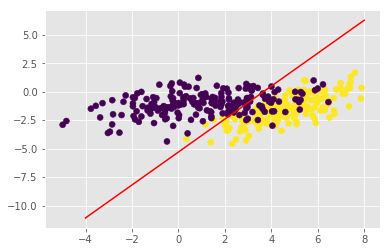

In [5]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_gen = partial(batch_generator, shuffle=True, batch_size=8)
model = MySGDClassifier(my_gen, max_epoch=10, C=1)
model.fit(X, y)

plot_decision_boundary(model)

plt.scatter(X[:,0], X[:,1], c=y)
# plt.ylim(-5,3)

Логистическая регрессия:

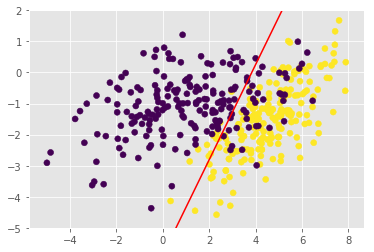

In [12]:
from functools import partial

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_gen = partial(batch_generator, shuffle=True, batch_size=1)
# лучше ослабить регуляризацию для логистической регрессии
model = MySGDClassifier(my_gen, max_epoch=20, model_type='log_reg', C=10)
model.fit(X, y)

plot_decision_boundary(model, theta=0.)
plt.ylim(-5,2)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [4]:
from sklearn.datasets import make_classification

In [5]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

Линейная регрессия

In [6]:
alpha_list = [0.00001,0.0001,0.001,0.01,0.1]

alpha_dict = {}
for alpha in tqdm(alpha_list):
    my_gen = partial(batch_generator, shuffle=True, batch_size=4096)
    model = MySGDClassifier(my_gen, alpha=alpha, max_epoch=10, model_type='lin_reg')
    model.fit(X, y)
    alpha_dict[alpha] = model.errors_log['loss']

100%|████████████████████████████████████████████| 5/5 [01:38<00:00, 19.66s/it]


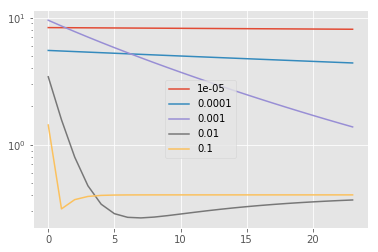

In [7]:
N=10

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for alpha in alpha_list:
    meaned_loss = [sum(alpha_dict[alpha][i:i+N])/N for i in range(0,len(alpha_dict[alpha]),N)]
    ax.plot(meaned_loss, label=alpha)
ax.set_yscale('log')
plt.legend()

Логистическая регрессия

In [8]:
alpha_list = [0.00001,0.0001,0.001,0.01,0.1]

alpha_dict = {}
for alpha in tqdm(alpha_list):
    my_gen = partial(batch_generator, shuffle=True, batch_size=4096)
    model = MySGDClassifier(my_gen, alpha=alpha, max_epoch=10, model_type='log_reg')
    model.fit(X, y)
    alpha_dict[alpha] = model.errors_log['loss']

100%|████████████████████████████████████████████| 5/5 [02:10<00:00, 26.35s/it]


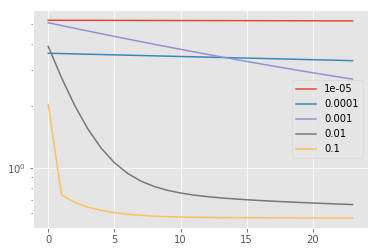

In [9]:
N=10

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for alpha in alpha_list:
    meaned_loss = [sum(alpha_dict[alpha][i:i+N])/N for i in range(0,len(alpha_dict[alpha]),N)]
    ax.plot(meaned_loss, label=alpha)
ax.set_yscale('log')
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [28]:
C_space = np.logspace(3,-3, 20)
lin_c_dict = {}
for C in tqdm(C_space):
    my_gen = partial(batch_generator, shuffle=True, batch_size=256)
    model = MySGDClassifier(my_gen, C=C, max_epoch=3, model_type='lin_reg')
    model.fit(X, y)
    lin_c_dict[C] = np.abs(model.weights).mean()

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 416.64it/s]


In [29]:
C_space = np.logspace(3,-3, 20)
log_c_dict = {}
for C in tqdm(C_space):
    my_gen = partial(batch_generator, shuffle=True, batch_size=256)
    model = MySGDClassifier(my_gen, C=C, max_epoch=3, model_type='log_reg')
    model.fit(X, y)
    log_c_dict[C] = np.abs(model.weights).mean()

  0%|                                                   | 0/20 [00:00<?, ?it/s]C:\Python36\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\Python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 317.44it/s]


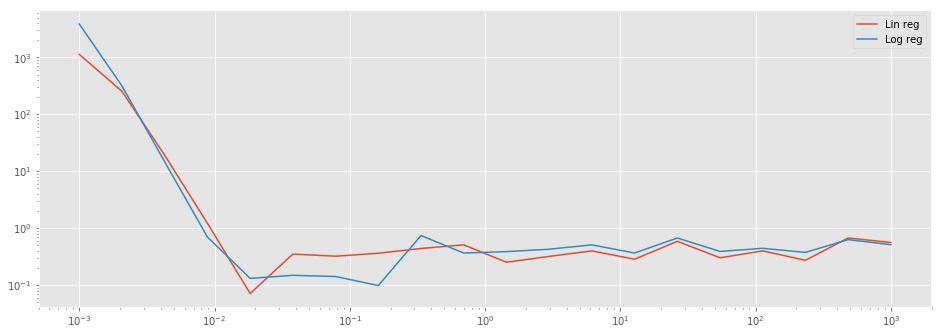

In [30]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2, 1, 1)

ax.plot(C_space, list(lin_c_dict.values()), label='Lin reg')
ax.plot(C_space, list(log_c_dict.values()), label='Log reg')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Заметное уменьшение весов достигается после $C=1e-2$. После этого, норма весов остается достаточно похожей

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [15]:
data_dir = 'E:/Datasets/anomaly-detection-competition-ml1-ts-fall-2019'

In [16]:
doc_to_title = {}
with open(data_dir+'/docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [17]:
import pandas as pd
train_data = pd.read_csv(data_dir+'/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [18]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [19]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from functools import partial

In [20]:
scaler = StandardScaler()
scaler.fit(X_train) # TODO: use test too
X_train = scaler.fit_transform(X_train)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [21]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [26]:
def validate(estimator, X_train, y_train, random_state=None, n_folds=5, train_part=1.0, threshold=0.5):

    if train_part < 1.0:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=1-train_part, random_state=random_state)
        print("Using only a fraction of dataset!")
    
    cv = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=random_state)
    cv_iter = list(cv.split(X_train, y_train))

    scores=[]
    for train, test in tqdm(cv_iter):
        estimator.fit(X_train[train, :], y_train[train])
        pred_statement = estimator.predict(X_train[test, :])
        pred_statement = (pred_statement > threshold) * 1
        # pred_statement = [1]*len(pred_statement)
        metric = f1_score(y_train[test], pred_statement)
        print(metric)
        scores.append(metric)
    return np.array(scores)

In [27]:
my_gen = partial(batch_generator, shuffle=True, batch_size=1024)
model = MySGDClassifier(my_gen, max_epoch=50, C=1e6, alpha=0.005, model_type='log_reg')
validate(model, X_train, y_train).mean()

  0%|                                                    | 0/5 [00:00<?, ?it/s]

0.569435637285986


 20%|████████▊                                   | 1/5 [00:05<00:20,  5.21s/it]C:\Python36\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


0.6261682242990654


 40%|█████████████████▌                          | 2/5 [00:10<00:15,  5.19s/it]

0.6288088642659281


 60%|██████████████████████████▍                 | 3/5 [00:15<00:10,  5.22s/it]

0.5725190839694656


 80%|███████████████████████████████████▏        | 4/5 [00:20<00:05,  5.11s/it]

0.6621893888515782


100%|████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]


0.6118242397344046

In [35]:
my_gen = partial(batch_generator, shuffle=True, batch_size=4096)
model = MySGDClassifier(my_gen, max_epoch=10, C=1e-4, alpha=0.01, model_type='lin_reg')
val = validate(model, X_train, y_train)
print(val.mean(), val.std())

  0%|                                                    | 0/5 [00:00<?, ?it/s]

0.5594493116395495


 20%|████████▊                                   | 1/5 [00:00<00:01,  2.44it/s]

0.6314344543582703


 40%|█████████████████▌                          | 2/5 [00:00<00:01,  2.38it/s]

0.6269633507853403


 60%|██████████████████████████▍                 | 3/5 [00:01<00:00,  2.68it/s]

0.5748129675810474


 80%|███████████████████████████████████▏        | 4/5 [00:01<00:00,  2.80it/s]

0.6864133934320669


100%|████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


0.6158146955592548 0.04518991861298455


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [44]:
my_gen = partial(batch_generator, shuffle=True, batch_size=4096)
model = MySGDClassifier(my_gen, max_epoch=10, C=1e-4, alpha=0.01, model_type='lin_reg')
val = validate(model, X_train, y_train, threshold=0.65)
print(val.mean(), val.std())

  0%|                                                    | 0/5 [00:00<?, ?it/s]

0.5617977528089888


 20%|████████▊                                   | 1/5 [00:00<00:01,  2.82it/s]

0.6282225237449117


 40%|█████████████████▌                          | 2/5 [00:00<00:00,  3.07it/s]

0.6307000642260757


 60%|██████████████████████████▍                 | 3/5 [00:00<00:00,  3.12it/s]

0.5721362229102166


 80%|███████████████████████████████████▏        | 4/5 [00:01<00:00,  3.21it/s]

0.6854942233632862


100%|████████████████████████████████████████████| 5/5 [00:01<00:00,  3.40it/s]


0.6156701574106959 0.04484707262749955


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук прислать Ваш ник на kaggle, под которым Вы залили решение, которое побило первый бейзлайн. **

In [29]:
import pandas as pd
test_data = pd.read_csv(data_dir+'/test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id = new_doc['pair_id']
    # target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, pair_id))

In [30]:
import numpy as np
X_test = []
pair_id_list = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, pair_id) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, pair_id_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        pair_id_list.append(pair_id)
X_test = np.array(X_test)
pair_id_list = np.array(pair_id_list)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [31]:
X_test = scaler.transform(X_test)

In [36]:
my_gen = partial(batch_generator, shuffle=True, batch_size=4096)
model = MySGDClassifier(my_gen, max_epoch=10, C=1e-4, alpha=0.01, model_type='lin_reg')
# model = MySGDClassifier(my_gen, max_epoch=1, C=1e1, alpha=0.00001, model_type='log_reg')
model.fit(X_train, y_train)

MySGDClassifier(C=0.0001, alpha=0.01,
                batch_generator=functools.partial(<function batch_generator at 0x00000000051CDB70>, shuffle=True, batch_size=4096),
                max_epoch=10, model_type='lin_reg')

In [37]:
threshold = 0.5
prediction = (model.predict(X_test) > threshold) * 1
prediction.mean()

0.3791423588139773

In [38]:
submit_df = pd.DataFrame()
submit_df['pair_id'] = pair_id_list
submit_df['target'] = prediction

In [39]:
submit_df.to_csv('submit.csv', index=False)

score: 0.60951
Название команды в Kaggle: Valentin Alexandrov

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***